## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.



### Dataset

In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
```

The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).


### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2 we are going to use all columns of the dataset.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-10-19 14:39:58--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1,4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1,36M  --.-KB/s    in 0,1s    

2023-10-19 14:39:58 (11,0 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [94]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb

In [4]:
data = pd.read_csv('housing.csv')

In [5]:
data.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [6]:
ocean_proximity_to_take = ['<1H OCEAN', 'INLAND']

In [10]:
data_filtered = data[data.ocean_proximity.isin(ocean_proximity_to_take)]
data_filtered.ocean_proximity.unique()

array(['<1H OCEAN', 'INLAND'], dtype=object)

In [12]:
data_filtered.info()


<class 'pandas.core.frame.DataFrame'>
Index: 15687 entries, 701 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           15687 non-null  float64
 1   latitude            15687 non-null  float64
 2   housing_median_age  15687 non-null  float64
 3   total_rooms         15687 non-null  float64
 4   total_bedrooms      15530 non-null  float64
 5   population          15687 non-null  float64
 6   households          15687 non-null  float64
 7   median_income       15687 non-null  float64
 8   median_house_value  15687 non-null  float64
 9   ocean_proximity     15687 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.3+ MB


In [101]:
data_filtered.ocean_proximity.replace('<1H OCEAN', '1H OCEAN', inplace=True)

/tmp/ipykernel_39319/2621379255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.ocean_proximity.replace('<1H OCEAN', '1H OCEAN', inplace=True)


In [102]:
data_filtered.fillna(0, inplace=True)

/tmp/ipykernel_39319/2757967836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.fillna(0, inplace=True)


In [103]:
data_filtered['median_house_value_log'] = data_filtered['median_house_value'].apply(np.log)

/tmp/ipykernel_39319/1161080476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['median_house_value_log'] = data_filtered['median_house_value'].apply(np.log)


In [104]:
data_train_full, data_test = train_test_split(data_filtered, test_size=0.2, random_state=1)

In [105]:
data_train, data_val = train_test_split(data_train_full, test_size=0.25, random_state=1)

In [106]:
y_train = data_train['median_house_value_log']
y_val = data_val['median_house_value_log']
y_test = data_test['median_house_value_log']

In [107]:
del data_train['median_house_value_log']
del data_val['median_house_value_log']
del data_test['median_house_value_log']

del data_train['median_house_value']
del data_val['median_house_value']
del data_test['median_house_value']

In [108]:
dv = DictVectorizer()

In [109]:
train = dv.fit_transform(data_train.to_dict(orient='records'))

In [110]:
val = dv.transform(data_val.to_dict(orient='records'))

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity` <--- this
* `total_rooms`
* `latitude`
* `population`


In [35]:
dt = DecisionTreeRegressor(max_depth=1)

In [36]:
dt.fit(train, y_train.values)

DecisionTreeRegressor(max_depth=1)

In [41]:
export_text(dt, feature_names=list(dv.get_feature_names_out()))

'|--- ocean_proximity=INLAND <= 0.50\n|   |--- value: [12.30]\n|--- ocean_proximity=INLAND >  0.50\n|   |--- value: [11.61]\n'

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245 <--- this
* 0.545
* 0.845

In [45]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

In [46]:
rf.fit(train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [50]:
y_val_predicted = rf.predict(val)

In [52]:
print(f'RMSE equals {mean_squared_error(y_val, y_val_predicted, squared=False)}')

RMSE equals 0.24543369440125373


## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 25
- 50
- 160 <--- this


In [55]:
rmse_results = []
for n_estimators in range(10, 200, 10):
    print(f'For n_estimator {n_estimators}')
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    rf.fit(train, y_train)
    y_val_predicted = rf.predict(val)
    _rmse = mean_squared_error(y_val, y_val_predicted, squared=False)
    print(f'RMSE {_rmse}')
    rmse_results.append(_rmse)

For n_estimator 10
RMSE 0.24543369440125373
For n_estimator 20
RMSE 0.23864067108125045
For n_estimator 30
RMSE 0.2373270065057849
For n_estimator 40
RMSE 0.23582551861671863
For n_estimator 50
RMSE 0.23565104239932427
For n_estimator 60
RMSE 0.23527743562200346
For n_estimator 70
RMSE 0.23487804681389055
For n_estimator 80
RMSE 0.23483336734289648
For n_estimator 90
RMSE 0.2345840158015108
For n_estimator 100
RMSE 0.2344700667354887
For n_estimator 110
RMSE 0.2343646081613448
For n_estimator 120
RMSE 0.23416966044282747
For n_estimator 130
RMSE 0.23397213347135978
For n_estimator 140
RMSE 0.23364939051982353
For n_estimator 150
RMSE 0.2334490796258388
For n_estimator 160
RMSE 0.2333459605261747
For n_estimator 170
RMSE 0.23329702650203693
For n_estimator 180
RMSE 0.23346118847420508
For n_estimator 190
RMSE 0.23367360050962918


Text(0.5, 1.0, 'Results')

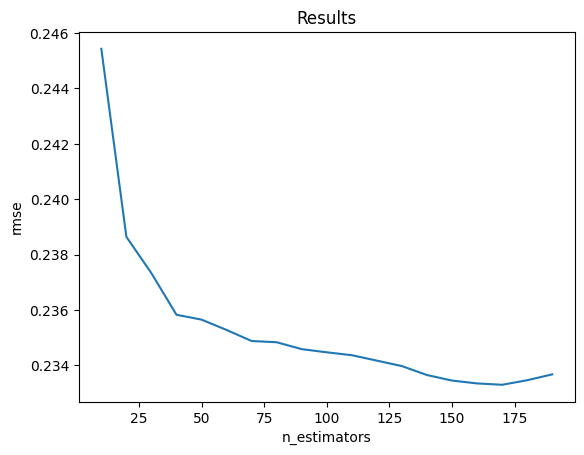

In [62]:
plt.plot(range(10, 200, 10), rmse_results)
plt.xlabel('n_estimators')
plt.ylabel('rmse')
plt.title('Results')

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20 <--- this
* 25

In [64]:
results = []
for max_depth in [10, 15, 20,25]:
    for n_estimators in range(10, 200, 10):
        print(f'For n_estimator {n_estimators}, max_depth {max_depth}')
        rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=1, n_jobs=-1)
        rf.fit(train, y_train)
        y_val_predicted = rf.predict(val)
        _rmse = mean_squared_error(y_val, y_val_predicted, squared=False)
        print(f'RMSE {_rmse}')
        results.append({'rmse': _rmse, 'max_depth': max_depth, 'n_estimators': n_estimators})

For n_estimator 10, max_depth 10
RMSE 0.2503817175522151
For n_estimator 20, max_depth 10
RMSE 0.24732043978848206
For n_estimator 30, max_depth 10
RMSE 0.2460788055387716
For n_estimator 40, max_depth 10
RMSE 0.24474669658557988
For n_estimator 50, max_depth 10
RMSE 0.24528901011790663
For n_estimator 60, max_depth 10
RMSE 0.24525877056149714
For n_estimator 70, max_depth 10
RMSE 0.24523964733119463
For n_estimator 80, max_depth 10
RMSE 0.2453792795355783
For n_estimator 90, max_depth 10
RMSE 0.24522860692889978
For n_estimator 100, max_depth 10
RMSE 0.2450355962717548
For n_estimator 110, max_depth 10
RMSE 0.2450897548460871
For n_estimator 120, max_depth 10
RMSE 0.24484030369603146
For n_estimator 130, max_depth 10
RMSE 0.2446503446449854
For n_estimator 140, max_depth 10
RMSE 0.24433344916271188
For n_estimator 150, max_depth 10
RMSE 0.24431468797708403
For n_estimator 160, max_depth 10
RMSE 0.24423250414485995
For n_estimator 170, max_depth 10
RMSE 0.24417521621225255
For n_estima

In [65]:
df_results = pd.DataFrame(results)

In [69]:
df_results_pivot = df_results.pivot(index='max_depth', columns=['n_estimators'], values=['rmse'])
df_results_pivot.round(4)

rmse                                                          \
n_estimators     10      20      30      40      50      60      70      80    
max_depth                                                                      
10            0.2504  0.2473  0.2461  0.2447  0.2453  0.2453  0.2452  0.2454   
15            0.2449  0.2388  0.2376  0.2359  0.2360  0.2359  0.2357  0.2361   
20            0.2438  0.2379  0.2361  0.2345  0.2347  0.2344  0.2344  0.2345   
25            0.2442  0.2383  0.2372  0.2353  0.2351  0.2348  0.2347  0.2348   

                                                                              \
n_estimators     90      100     110     120     130     140     150     160   
max_depth                                                                      
10            0.2452  0.2450  0.2451  0.2448  0.2447  0.2443  0.2443  0.2442   
15            0.2358  0.2354  0.2353  0.2352  0.2350  0.2347  0.2346  0.2344   
20            0.2344  0.2342  0.2343  0.2342  0.2340  0.2336  0.2335  0.2334   
25            0.2345  0.2344  0.2344  0.2342  0.2340  0.2337  0.2336  0.2334   

                                      
n_estimators     170     180     190  
max_depth                             
10            0.2442  0.2443  0.2445  
15            0.2344  0.2346  0.2348  
20            0.2333  0.2335  0.2338  
25            0.2334  0.2336  0.2338

Text(0.5, 1.0, 'RMSE-Results')

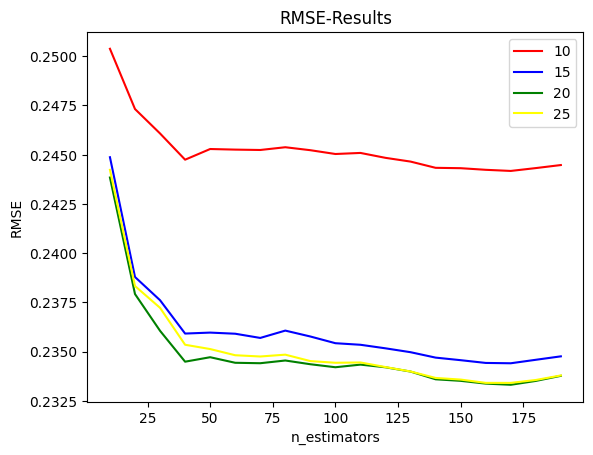

In [86]:
colors = {10: 'red', 15: 'blue', 20: 'green', 25: 'yellow'}
for max_depth in [10, 15, 20, 25]:
    plt.plot(range(10, 200, 10), df_results_pivot[df_results_pivot.index == max_depth].T.values, color = colors[max_depth], label=max_depth)
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('RMSE-Results')

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income` <--- this
* `total_bedrooms`
* `longitude`

In [87]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)

In [88]:
rf.fit(train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [90]:
feature_importance = pd.DataFrame({'feature_importance':rf.feature_importances_, 'features': dv.get_feature_names_out()})

In [93]:
feature_importance.sort_values('feature_importance', ascending=False)

,feature_importance,features
6,0.366280,ocean_proximity=INLAND
4,0.335320,median_income
2,0.101279,latitude
3,0.086834,longitude
1,0.030134,housing_median_age
7,0.027851,population
9,0.021493,total_rooms
8,0.015465,total_bedrooms
0,0.015343,households
5,0.000000,ocean_proximity=<1H OCEAN



## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value <--- this

In [111]:
features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(train, label=y_train, feature_names=features)
dval = xgb.DMatrix(val, label=y_val, feature_names=features)

/home/taras/.local/share/virtualenvs/ml-zoomcamp-hw-yGiuWYQQ/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


In [112]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [128]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [129]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [130]:
df_score = parse_xgb_output(output)

In [131]:
df_score

,num_iter,train_rmse,val_rmse
0,0,0.44351,0.44250
1,5,0.25338,0.27463
2,10,0.21445,0.25179
3,15,0.19858,0.24523
4,20,0.18524,0.23978
5,25,0.17757,0.23830
6,30,0.16888,0.23571
7,35,0.16113,0.23416
8,40,0.15542,0.23319
9,45,0.14941,0.23190


In [132]:
df_score.val_rmse.min()

0.22865

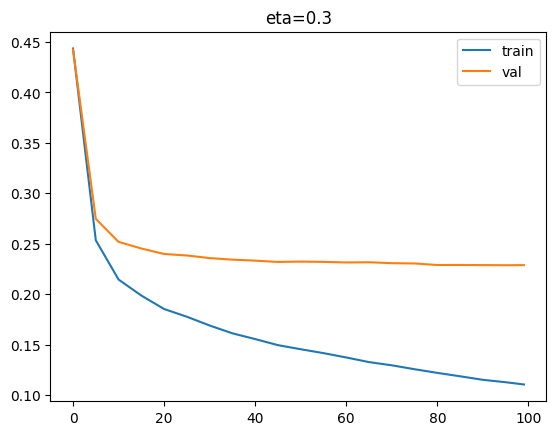

In [121]:
plt.plot(df_score.num_iter, df_score.train_rmse, label='train')
plt.plot(df_score.num_iter, df_score.val_rmse, label='val')
plt.title('eta=0.3')
plt.legend()

In [122]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

In [124]:
%%capture output

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [125]:
df_score = parse_xgb_output(output)

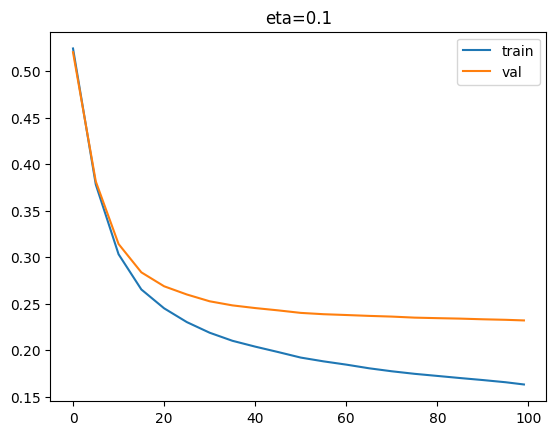

In [126]:
plt.plot(df_score.num_iter, df_score.train_rmse, label='train')
plt.plot(df_score.num_iter, df_score.val_rmse, label='val')
plt.title('eta=0.1')
plt.legend()

In [127]:
df_score.val_rmse.min()

0.23209